# Report 3: Computational Bayesian Statistics
## Taylor Sheneman

In [114]:
from __future__ import print_function, division

import numpy as np
import random

import thinkbayes2
from thinkbayes2 import Pmf, Cdf, Suite, Joint, MakeBinomialPmf, Beta, MakeMixture
import thinkplot

import scipy.stats as stats

from itertools import product
from operator import truediv

% matplotlib inline

## Problems from Think Bayes Chapter 9 Notes

Worked problems from Allen Downey's Think Bayes supplementary materials.

### Lincoln Index Problem

"Suppose you have a tester who finds 20 bugs in your program. You want to estimate how many bugs are really in the program. You know there are at least 20 bugs, and if you have supreme confidence in your tester, you may suppose there are around 20 bugs. But maybe your tester isn't very good. Maybe there are hundreds of bugs. How can you have any idea how many bugs there are? There’s no way to know with one tester. But if you have two testers, you can get a good idea, even if you don’t know how skilled the testers are.

"Suppose two testers independently search for bugs. Let k1 be the number of errors the first tester finds and k2 the number of errors the second tester finds. Let c be the number of errors both testers find. The Lincoln Index estimates the total number of errors as k1 k2 / c [I changed his notation to be consistent with mine]."

So if the first tester finds 20 bugs, the second finds 15, and they find 3 in common, we estimate that there are about 100 bugs. What is the Bayesian estimate of the number of errors based on this data?

p1 = P(tester #1 finds a given bug)

p2 = P(tester #2 finds a given bug)

n = number of bugs


k1 = # bugs found by tester #1

k2 = # bugs found by tester #2

c = # bugs found by both

In [2]:
p1 = 0.2
p2 = 0.1
n = 100

p1_trials = np.random.random(n) < p1
p2_trials = np.random.random(n) < p2

k1 = np.sum(p1_trials)
k2 = np.sum(p2_trials)
c = np.sum(p1_trials & p2_trials)

print(k1)
print(k2)
print(c)

16
13
1


The simulation produces about the output one would expect, given the trial conditions.

In [3]:
class LincolnIndex(Suite, Joint):
    
    def __init__(self,p1s,p2s,ns):
        """Makes a joint suite of parameters p1, p2, and n

        Enumerates all combinations of p1, p2, n

        p1s: possible probabilities that tester #1 finds a bug
        p2s: possible probabilities that tester #1 finds a bug
        ns: possible numbers of bugs"""
        
        combinations = product(p1s,p2s,ns)
        Suite.__init__(self, combinations)
    
    def Likelihood(self, data, hypos):
        """computes likelihood of data (k1, k2, c) given 
        hypo (p1, p2, n)"""
        k1, k2, c = data
        p1, p2, n = hypos
        
        like1 = stats.binom.pmf(k1, n, p1)
        like2 = stats.binom.pmf(k2, n, p2)
        like_both = stats.binom.pmf(c, n, p1*p2)
        
        return like1*like2*like_both
    

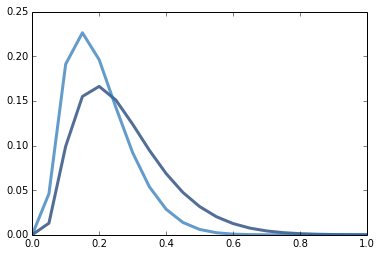

In [4]:
p1 = Beta(1,1)
p2 = Beta(1,1)
n = Pmf(range(350))

suite = LincolnIndex(p1.MakePmf(21),p1.MakePmf(21),n)
suite.Update((20,15,3))
thinkplot.Pdf(suite.Marginal(0))
thinkplot.Pdf(suite.Marginal(1))

In [5]:
print("Mean of p1:",suite.Marginal(0).Mean())
print("MAP of p1:",suite.Marginal(0).MAP())
print("Mean of p2:",suite.Marginal(1).Mean())
print("MAP of p2:",suite.Marginal(1).MAP())

Mean of p1: 0.27013203389
MAP of p1: 0.2
Mean of p2: 0.199301060402
MAP of p2: 0.15


The probable sensitivity of the testers to the presence of bugs falls within the ranges above. The mean probabilities that they will catch a given bug are 0.27 and 0.20, respectively.

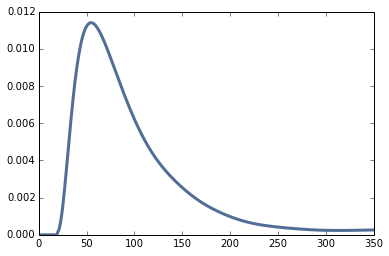

In [6]:
thinkplot.Pdf(suite.Marginal(2))

In [7]:
print("Mean of n:",suite.Marginal(2).Mean())
print("MAP of n:",suite.Marginal(2).MAP())

Mean of n: 95.3343021466
MAP of n: 55


The model suggests that the mean probable number of bugs is around 95, while the maximum probability for a single value of n falls around 55. This isn't totally consistent with the Lincoln Index rule of thumb, which (due to my lack of confidence in my model) leads to me further doubting the likelihood function, rather than the usefulness of the LI.

*I've spent an unfortunately long time on this problem. I strongly suspect that I did not come up with the correct likelihood function, but I really need to move on at this point.*

### Rain in Seattle

You're about to get on a plane to Seattle. You want to know if you should bring an umbrella. You call 3 random friends of yours who live there and ask each independently if it's raining. Each of your friends has a 2/3 chance of telling you the truth and a 1/3 chance of messing with you by lying. All 3 friends tell you that "Yes" it is raining. What is the probability that it's actually raining in Seattle?

In [26]:
rainHoursMonthly = [137,107,104,74,48,37,21,25,40,71,124,134]
hoursMonthly = [x*24 for x in [31,28,31,30,31,30,31,31,30,31,30,31]]
percRainMonthly = map(truediv,rainHoursMonthly,hoursMonthly)
percRainMonthly = np.array(percRainMonthly)
avRain = np.average(percRainMonthly,weights=hoursMonthly)
stdRain = percRainMonthly.std()

In [30]:
def MakeGaussianPmf(mu, sigma, num_sigmas, n=101):
    """This is taken from the book, I'd like a Gaussian prior"""
    
    pmf = Pmf()
    low = mu - num_sigmas*sigma
    high = mu + num_sigmas*sigma
    
    for x in np.linspace(low, high, n):
        p = stats.norm.pdf(x, mu, sigma)
        pmf.Set(x, p)
    pmf.Normalize()
    return pmf

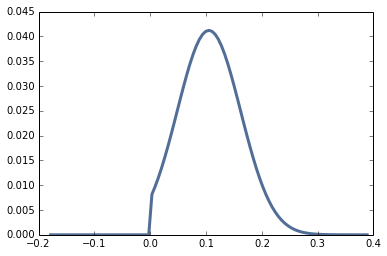

In [60]:
rainPrior = MakeGaussianPmf(avRain, stdRain, 5)
for key in rainPrior:
    if float(key) < 0:
        rainPrior[key] = 0
rainPrior.Normalize()
thinkplot.Pdf(rainPrior)

In [109]:
class Rain(Suite):
    
    def Likelihood(self,data,hypo):
        """Computes probability of data given hypo
        
        data = 'yes' or 'no' to "is it raining?"
        hypo = whether it's raining or not
        """
        if hypo == 'raining':
            if data == 'yes':
                like = 0.66
            else:
                like = 0.33
        else:
            if data == 'yes':
                like = 0.33
            else:
                like = 0.66
        
        return like

In [110]:
suite = Rain(dict([('raining',avRain),('notRaining',1-avRain)]))
suite.Update('yes')
suite.Update('yes')
suite.Update('yes')
print(suite)

Rain({'raining': 0.48481661627448408, 'notRaining': 0.51518338372551586})


I made this way harder than it needed to be, trying to make the hypotheses a distribution of probabilities of rain, with a Gaussian prior. That's really not the right option here though. With a simple two-part hypothesis, the final result is around a 52% chance that it's actually raining.

### Alien Blaster Problem

(Though we did this in class, I am reproducing the section on metapmfs and mixtures here, plus my explanations, for my benefit)

Suppose we
have we have a stockpile of 3 Alien Blaster 9000s and 7 Alien
Blaster 10Ks.  After extensive testing, we have concluded that
the AB9000 hits the target 40% of the time, precisely, and the
AB10K hits the target 50% of the time.

If I grab a random weapon from the stockpile and shoot at 10 targets,
what is the probability of hitting exactly 3?  Again, you can write a
number, mathematical expression, or Python code.

In [122]:
n = 10
x1 = 0.4
x2 = 0.5

In [123]:
pmf1 = MakeBinomialPmf(n, x1)
pmf2 = MakeBinomialPmf(n, x2)

metapmf = Pmf({pmf1:0.3, pmf2:0.7})
metapmf.Print()

Pmf({0: 0.0009765625, 1: 0.0097656250000000104, 2: 0.043945312499999993, 3: 0.11718750000000014, 4: 0.20507812500000022, 5: 0.24609375000000025, 6: 0.20507812500000022, 7: 0.11718750000000014, 8: 0.043945312499999993, 9: 0.0097656250000000104, 10: 0.0009765625}) 0.7
Pmf({0: 0.0060466176, 1: 0.040310784000000037, 2: 0.12093235199999994, 3: 0.21499084800000012, 4: 0.2508226560000002, 5: 0.20065812480000034, 6: 0.11147673600000013, 7: 0.04246732800000004, 8: 0.010616832, 9: 0.0015728640000000028, 10: 0.00010485760000000014}) 0.3


The metaPmf is a pmf of pmfs, with associated weights. The chance that you will select an Alien Blaster 9000 is the chance that you will end up in the first binomial distribution, and the probability that you select the other is the chance that you will end up in the second distribution, much like an expanded probability tree. The probability of hitting any given branch of the meta-pmf is the probability of the branch within the distribution, multiplied by the original weight.

4.7
P(hitting exactly 3): 0.1465285044


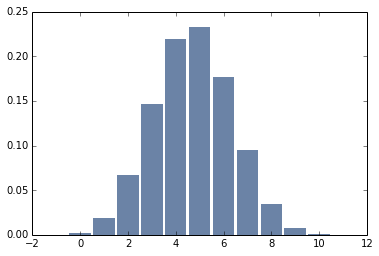

In [141]:
mix = MakeMixture(metapmf)
thinkplot.Hist(mix)
print(mix.Mean())
print('P(hitting exactly 3):',mix[3])

Assuming again that the distribution of `x` in the population of designs is well-modeled by a beta distribution with parameters α=2 and β=3, what the distribution if `k` if I choose a random Alien Blaster and fire 10 shots?

In [142]:
beta = Beta(2,3).MakePmf()

In [144]:
metapmf = Pmf()
for x, prob in beta.Items():
    # binomial distribution for a given blaster
    nested_pmf = MakeBinomialPmf(n,x)
    # assigns weight of the distribution to the p in the outer beta
    metapmf[nested_pmf] = prob

P(hitting exactly 3): 0.143870530961


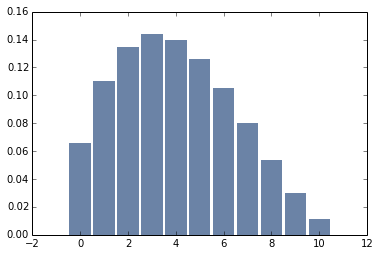

In [146]:
mix = MakeMixture(metapmf)
thinkplot.Hist(mix)
print('P(hitting exactly 3):',mix[3])

## Original Bayes problem!
### The Most Dangerous Corn Maze

(I didn't come up with this scenario: it is a game invented last year by two other students, Nur and Evan, modified into a potential Bayes problem)

You and your nemesis are embroiled in a duel to the death, in a rather unconventional scenario: you find yourselves in a very dark corn maze, each armed with a powerful and accurate single-shot rifle. You quickly discover (with your uncanny intuition) that this is no normal corn maze; it is, rather, a 5x5 grid of isolated looping space, in which each edge of the maze's grid leads to the corresponding space on the opposite edge. No space is bounded by more than two walls.

It's nearly pitch black, and you operate mostly by touch and sound. You are aware of the arrangement of walls immediately around you, but no further. You alternate moves with your opponent, each time learning the arrangement of walls in your new space; however, both you and your opponent have inhumanly good hearing, and can determine the same information (direction moved, new arrangement of walls) from the quality of the sound echoing through the maze.

Your gun is powerful, and you know that you can end this deadly, deliberate dance in a single shot, preferably before you suffer the same fate at the hands of your nemesis. However, if you fire and miss, you will have to take a precious moment to reload, and due to the nature of the local space, you always run the risk of accidentally shooting yourself in the back. Fortunately, the bullets don't seem to pass through the walls, so you might get a second chance.

1. A few turns are taken. Where is your opponent? Can you find the most likely places to shoot, before your opponent gets off a lucky shot?

2. You find yourself in a new maze, of size NxN, where N is somewhere between 3 and 10. The same rules apply.

3. You and your opponent discover a way to move more quietly, without giving the other direction information. You still know the new arrangement of walls. How does this affect your estimates?

A blank starting grid:

┌───┬───┬───┬───┬───┐


├───┼───┼───┼───┼───┤


├───┼───┼───┼───┼───┤


├───┼───┼───┼───┼───┤


├───┼───┼───┼───┼───┤



└───┴───┴───┴───┴───┘

In [148]:
class CornMaze(Suite, Joint):
    
    def __init__(self,xs,ys):
        """Makes a joint suite of parameters x, y

        Enumerates all combinations of x, y

        x: horizontal grid positions
        y: vertical grid positions
        """
        
        coordinates = product(xs,ys)
        self.spaces = np.empty((5,5),dtype=list)
        Suite.__init__(self, coordinates)
        
    
    def Likelihood(self, data, hypos):
        """computes likelihood of data (w1,w2,w3,w4) given 
        hypo (x, y)"""
        w1,w2,w3,w4 = data
        x,y = hypos
        
        # if a space is known and the walls don't match
        if self.spaces[x,y] != [w1,w2,w3,w4]:
            like = 0
        
        # the input data also updates known or probable information about
        # surrounding squares, possibly different update function for
        # your moves? Will also affect probabilities for the other walls
        # of surrounding squares, due to 2 wall maximum. The wall lists
        # in the spaces array need to be probabilistic too, which affects
        # likely position in the maze for a given configuration. Needs
        # to take into account prior positions. Each update then updates
        # both the two dimensional distribution of possible current
        # opponent positions and the probabilistic configuration of the
        # maze...would probably need to overload a lot more functions
        # in the class.
        
        return like

So it turns out, I suppose unsurprisingly, that this is a really hard problem. It was a very hard game to play, and though I simplified things somewhat for the problem, it's still kind of overwhelming. I think with further simplification it could work, though. Probably best in any case to work up from the simplest case (known maze of known size), but that's not a particularly interesting problem on its own.

I'm not favoring finishing this particular problem for the final project, but I seem to be stuck on spatial probability density maps; my current idea is to start with an alien abduction dropping you in a random location (but this time on Earth, not hyperdimensional corn maze space) and using some limited information (approximate temperature, trees or not, mountains within eyesight, maybe a street name) generate a probability density map of where in the world you might be. The more irrelevant-seeming the data, the better.